In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax

I0000 00:00:1695242171.179364  289742 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [45]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)
enumerators = b.make_enumerator([f"contact_params_1"])

In [81]:
grid_params = [
    (0.5, jnp.pi, (11,11,21)), (0.4, jnp.pi/2, (11,11,21)), (0.1, jnp.pi/2, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi/3, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.1, 0.0, (21,21,1)),(0.1, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [4]:


# all_data = pickle.load(open(paths[2], "rb"))
# IDX = 1
# data = all_data[IDX]


dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


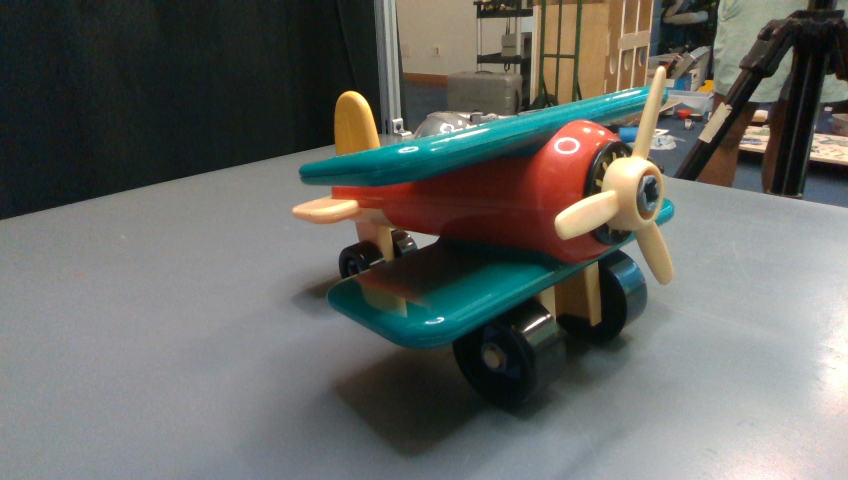

In [115]:
paths = glob.glob(
    # "panda_scans_v5/*.pkl"
    "panda_dataset/*.pkl"
)
all_data = pickle.load(open(paths[0], "rb"))
IDX = 8
data = all_data[IDX]
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
b.get_rgb_image(rgbd_original.rgb)

In [116]:
if b.RENDERER is None:
    b.setup_renderer(rgbd_scaled_down.intrinsics)
    # b.RENDERER.add_mesh_from_file("toy_final.ply")
    cloud = np.load("plane_pc_video_capture.npy")
    mesh  = b.utils.make_voxel_mesh_from_point_cloud(cloud, 0.007)
    b.show_trimesh("2", mesh)
    b.RENDERER.add_mesh(mesh)

    b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

In [117]:
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [118]:
plane_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics), jnp.eye(4), rgbd_scaled_down.intrinsics, 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)
mask = b.utils.scale(carvekit_get_foreground_mask(rgbd_original)*1.0, scaling_factor)
observed_depth = (rgbd_scaled_down.depth * mask) + (1.0 - mask)* rgbd_scaled_down.intrinsics.far
b.clear()
b.show_cloud("1", b.unproject_depth(observed_depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", plane_pose)

In [119]:

weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(1),
    "id_1": jnp.int32(0),
    "camera_pose": jnp.eye(4),
    "root_pose_0": plane_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": b.unproject_depth(observed_depth, rgbd_scaled_down.intrinsics),
    "variance": 0.0001,
    "outlier_prob": 0.0001,
    "contact_params_1": jnp.array([0.0, 0.0, jnp.pi/2])
}), (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-2.2, -2.2, -15*jnp.pi]), jnp.array([2.2, 2.2, 15*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, 1.0)
)
b.viz_trace_meshcat(trace)
print(trace.get_score())
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[f"contact_params_1"]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    print(trace["contact_params_1"])
    b.viz_trace_meshcat(trace)

-9736.715
[ 0.         0.        -0.9424778]
[ 1.4901161e-08  1.4901161e-08 -7.8539819e-01]


[-1.9999985e-02  1.8626451e-08 -1.0995575e+00]
[-0.02999998  0.01000002 -1.0995575 ]
[-0.02999998  0.01000002 -1.0576696 ]
[-0.02799998  0.01400002 -0.9320059 ]
[-0.02799998  0.01400002 -0.9320059 ]
[-0.02799998  0.01400003 -0.9320059 ]


In [105]:
trace = b.update_address(trace, key, "contact_params_1", jnp.array([0.0, 0.0, jnp.pi]) + trace["contact_params_1"])
b.viz_trace_meshcat(trace)

In [106]:

print(trace.get_score())
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[f"contact_params_1"]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    print(trace["contact_params_1"])
    b.viz_trace_meshcat(trace)

-40490.67
[-1.78      -1.78      -7.4351025]
[-2.18     -2.18     -9.005898]


[ -2.2        -2.2       -10.5766945]
[ -2.2       -2.2      -11.623892]
[ -2.2       -2.2      -12.671089]
[ -2.2       -2.2      -13.299408]
[ -2.2       -2.2      -13.299408]
[ -2.2       -2.2      -13.299408]


In [98]:
trace["contact_params_1"]

Array([ 0.202     , -0.17199998,  2.0839233 ], dtype=float32)

In [20]:
x = 0.01
ang = 0.0
nums = (21,21,1)
contact_param_gridding_schedule = [
     b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for _ in range(5)
]

In [21]:
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[f"contact_params_1"]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    print(trace["contact_params_1"])
    b.viz_trace_meshcat(trace)

[0.01900001 0.03300001 0.62831867]
[0.01900001 0.03300001 0.62831867]
[0.01900001 0.03300001 0.62831867]
[0.01900001 0.03300001 0.62831867]
[0.01900001 0.03300001 0.62831867]


In [86]:
b.RENDERER.model_box_dims

Array([[2.87e-01, 2.87e-01, 1.57e-01],
       [1.00e-09, 1.00e-09, 1.00e-09]], dtype=float32)

In [87]:
b.clear()

In [155]:
b.show_trimesh("1", b.RENDERER.meshes[0])

In [22]:
cloud = np.load("plane_pc_video_capture_hi_res.npy")
b.clear()
b.show_cloud("1", cloud)

In [35]:
cloud_voxelized = b.utils.voxelize(cloud, 0.007)

In [36]:
cloud_voxelized.shape

(3447, 3)